# Movement of particles in cylindrical geometry

This demo shows the movement of particles and reflection from walls.

#### Prepare simulation

Import libraries, create default configuration and get pointers to data.

In [1]:
import parfis as pfs
from parfis import Parfis
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib import animation
from copy import copy

Parfis.load_lib()
id = Parfis.newParfis()
Parfis.loadCfgData(id)
Parfis.loadSimData(id)
success = Parfis.runCommandChain(id, "create")
print("Create success") if success == 0 else print("Create fail")
Parfis.setPyCfgData(id)
ptrCfgData = Parfis.getPyCfgData(id)
Parfis.setPySimData(id)
ptrSimData = Parfis.getPySimData(id)
cellSize = ptrCfgData[0].cellSize[0]
geoSize = ptrCfgData[0].geometrySize[0]
cellCount = ptrCfgData[0].cellCount[0]
print(f"cellSize = {cellSize} meters")
print(f"geoSize = {geoSize} meters")
print(f"cellCount = {cellCount}")

Successfully loaded lib file: libparfis64.so
Create success
cellSize = {x: 0.001, y: 0.001, z: 0.001} meters
geoSize = {x: 0.02, y: 0.02, z: 0.4} meters
cellCount = {x: 20, y: 20, z: 400}


Choose some cells that are on the boundary.

Selected 11 for presentation


TypeError: add_patch() takes 2 positional arguments but 13 were given

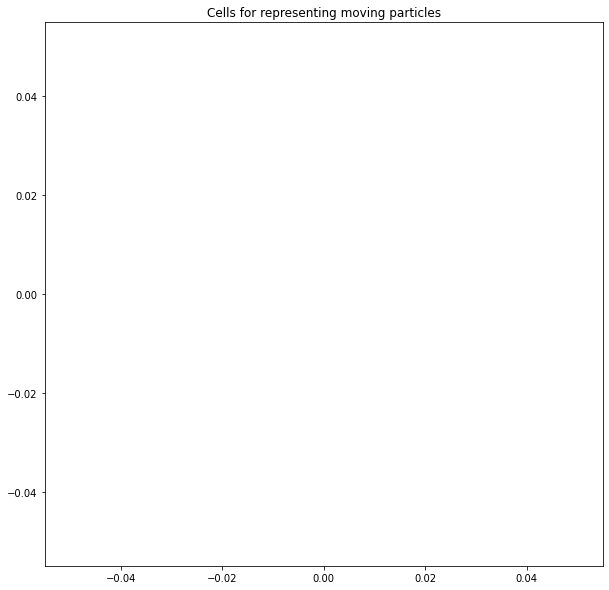

In [3]:
zSlice = 100
xRange = [i for i in range(15, 20)]
yRange = [i for i in range(15, 20)]
cellPos = pfs.Vec3DClass(pfs.Type.cellPos_t)(z=zSlice)
cellIdRange = []
for i in xRange:
    cellPos.x = i
    for j in yRange:
        cellPos.y = j
        cellId = ptrSimData[0].cellIdVec.ptr[pfs.getAbsoluteCellId(cellCount, cellPos)]
        if cellId != pfs.Const.noCellId:
            cellIdRange.append(cellId)
print(f"Selected {len(cellIdRange)} for presentation")

# Save grid patches for later drawings

# Draw the cells
fig, axGrid = plt.subplots(figsize=(10, 10))
axGrid.set_title("Cells for representing moving particles")
axGrid.plot()

gridPatches = []
for cellId in cellIdRange:
    pos = ptrSimData[0].cellVec.ptr[cellId].pos
    gridPatches.append (
        patches.Rectangle(
            (cellSize.x*pos.x, cellSize.y*pos.y),
            cellSize.x, cellSize.y,
            edgecolor = 'blue',
            alpha = 0.5,
            fill=False
        ) 
    )
# Draw the geometry bound
gridPatches.append (
patches.Circle(
    (geoSize.x*0.5, geoSize.y*0.5),
    radius=geoSize.x*0.5,
    lw = 2,
    edgecolor = 'red',
    alpha = 0.5,
    fill=False
    ) 
)

for i in range(len(gridPatches)):
    axGrid.add_patch(copy(gridPatches[i]))
axGrid.set_xlim((xRange[0] - 1)*cellSize.x, (xRange[-1] + 1)*cellSize.x)
axGrid.set_ylim((yRange[0] - 1)*cellSize.y, (yRange[-1] + 1)*cellSize.y)
axGrid.set_aspect('equal')
plt.show()

#### Evolve states and move particles

In [6]:
# Number of frames to run the simulation
numFrames = 100
# Size of a particle in the animation
particleSize = 0.01*cellSize.x
# Save animation as mp4
saveAnimation = True

# Dictionary of the format {stateId: [patch, pushed]}
knownState = dict()

pc = ['blue', 'red']

# Draw the cells
fig, ax = plt.subplots(figsize=(10, 10))
ax.set_title("Cells for representing moving particles")
ax.set_xlim((xRange[0] - 1)*cellSize.x, (xRange[-1] + 1)*cellSize.x)
ax.set_ylim((yRange[0] - 1)*cellSize.y, (yRange[-1] + 1)*cellSize.y)
ax.set_aspect('equal')

for i in range(len(gridPatches)):
    ax.add_patch(copy(gridPatches[i]))

def update(i):
    Parfis.runCommandChain(id, "evolve")

    for stateId in knownState.keys():
        knownState[stateId][1] = 0

    for cid in cellIdRange:
        xOff = ptrSimData[0].cellVec.ptr[cid].pos.x*cellSize.x
        yOff = ptrSimData[0].cellVec.ptr[cid].pos.y*cellSize.y
        stateId = ptrSimData[0].headIdVec.ptr[cid]
        while stateId != pfs.Const.noStateId:
            state = ptrSimData[0].stateVec.ptr[stateId]
            # If new state - add patch for it
            if stateId not in knownState.keys():
                ax.add_patch(
                    patches.Circle(
                        (
                            state.pos.x*cellSize.x + xOff, 
                            state.pos.y*cellSize.y + yOff),
                        radius=particleSize,
                        color="green",
                        fill=True
                    )
                )
                knownState[stateId] = [ax.patches[-1], 1]
            else:
                knownState[stateId][1] = 1
                knownState[stateId][0].center = (
                    state.pos.x*cellSize.x + xOff, 
                    state.pos.y*cellSize.y + yOff)

            stateId = state.next

    for stateId in list(knownState):
        if knownState[stateId][1] == 0:
            ax.patches.remove(knownState[stateId][0])
            del knownState[stateId]

    return ax.patches + ax.texts


anim = animation.FuncAnimation(fig, update, frames=numFrames, blit=True, interval=50)

# fig.axes.append(axGrid)

if saveAnimation:
    from IPython import display
    plt.ioff()
    # plt.rcParams()
    video = anim.to_html5_video()
    html = display.HTML(video)
    display.display(html)
    plt.close()
        # Writer = animation.writers['ffmpeg']
        # writer = Writer(fps=30, metadata=dict(artist='parfis'), bitrate=7200)
        # anim.save('demo_move_cylindrical.mp4', writer=writer)
else:
    plt.show()